In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Features Dataset

Load the engineered features from the previous notebook.

In [2]:
# Define path to features file
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
# Original features: 'features.csv' (all engineered features)
# PCA features: 'features_pca.csv' (dimensionality-reduced, faster training)
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features for faster training and reduced overfitting')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

# Check if file exists
if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
    if USE_PCA_FEATURES:
        print('Please run notebook 03_feature_engineering.ipynb first to generate PCA features.')
    else:
        print('Please run notebook 03_feature_engineering.ipynb first to generate the features file.')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully from {features_path}')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully from c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\features.csv
Dataset shape: (58817, 84)


In [3]:
# Display first few rows
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Is_laundering,timestamp,Payment_currency_Albanian lek,Payment_currency_Dirham,Payment_currency_Euro,Payment_currency_Indian rupee,Payment_currency_Mexican Peso,Payment_currency_Moroccan dirham,Payment_currency_Naira,Payment_currency_Pakistani rupee,Payment_currency_Swiss franc,Payment_currency_Turkish lira,Payment_currency_UK pounds,Payment_currency_US dollar,Payment_currency_Yen,Received_currency_Albanian lek,Received_currency_Dirham,Received_currency_Euro,Received_currency_Indian rupee,Received_currency_Mexican Peso,Received_currency_Moroccan dirham,Received_currency_Naira,Received_currency_Pakistani rupee,Received_currency_Swiss franc,Received_currency_Turkish lira,Received_currency_UK pounds,Received_currency_US dollar,Received_currency_Yen,Sender_bank_location_Albania,Sender_bank_location_Austria,Sender_bank_location_France,Sender_bank_location_Germany,Sender_bank_location_India,Sender_bank_location_Italy,Sender_bank_location_Japan,Sender_bank_location_Mexico,Sender_bank_location_Morocco,Sender_bank_location_Netherlands,Sender_bank_location_Nigeria,Sender_bank_location_Pakistan,Sender_bank_location_Spain,Sender_bank_location_Switzerland,Sender_bank_location_Turkey,Sender_bank_location_UAE,Sender_bank_location_UK,Sender_bank_location_USA,Receiver_bank_location_Albania,Receiver_bank_location_Austria,Receiver_bank_location_France,Receiver_bank_location_Germany,Receiver_bank_location_India,Receiver_bank_location_Italy,Receiver_bank_location_Japan,Receiver_bank_location_Mexico,Receiver_bank_location_Morocco,Receiver_bank_location_Netherlands,Receiver_bank_location_Nigeria,Receiver_bank_location_Pakistan,Receiver_bank_location_Spain,Receiver_bank_location_Switzerland,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_ACH,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card,log_amount,hour,weekday,total_outgoing,num_outgoing,total_incoming,num_incoming,number_transactions
0,5387,136,5402012602,1511156942,4266.06,0,2023-02-20 07:36:23,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,8.358680,7,0,4266.06,1,4266.06,1,2
1,4725,151,8401844213,3742608142,10624.52,0,2023-03-07 06:42:14,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,9.271014,6,1,10624.52,1,25389.15,2,3
2,10308,1,6465571183,8296980377,180.22,0,2022-10-08 10:06:13,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,5.199712,10,5,33413.81,5,180.22,1,6
3,24742,224,2612843052,960360534,13546.65,0,2023-05-19 16:43:42,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,

In [4]:
# Check column names and data types
print('Columns in dataset:')
print(df.columns.tolist())
print(f'\nData types:')
print(df.dtypes)

Columns in dataset:
['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'timestamp', 'Payment_currency_Albanian lek', 'Payment_currency_Dirham', 'Payment_currency_Euro', 'Payment_currency_Indian rupee', 'Payment_currency_Mexican Peso', 'Payment_currency_Moroccan dirham', 'Payment_currency_Naira', 'Payment_currency_Pakistani rupee', 'Payment_currency_Swiss franc', 'Payment_currency_Turkish lira', 'Payment_currency_UK pounds', 'Payment_currency_US dollar', 'Payment_currency_Yen', 'Received_currency_Albanian lek', 'Received_currency_Dirham', 'Received_currency_Euro', 'Received_currency_Indian rupee', 'Received_currency_Mexican Peso', 'Received_currency_Moroccan dirham', 'Received_currency_Naira', 'Received_currency_Pakistani rupee', 'Received_currency_Swiss franc', 'Received_currency_Turkish lira', 'Received_currency_UK pounds', 'Received_currency_US dollar', 'Received_currency_Yen', 'Sender_bank_location_Albania', 'Sender_bank_location_Austria', 'Sender_bank

In [5]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())

Missing values per column:
Time                   0
Date                   0
Sender_account         0
Receiver_account       0
Amount                 0
                      ..
total_outgoing         0
num_outgoing           0
total_incoming         0
num_incoming           0
number_transactions    0
Length: 84, dtype: int64


## 2. Define Features and Target

Separate the features (X) from the target label (y). The target is typically named 'is_laundering', 'is_fraud', or similar.

In [6]:
# Identify target column (common names for AML datasets)
target_col = "Is_laundering"

print(f'\nClass distribution:')
print(df[target_col].value_counts())
print(f'\nClass proportions:')
print(df[target_col].value_counts(normalize=True))


Class distribution:
Is_laundering
0    49219
1     9598
Name: count, dtype: int64

Class proportions:
Is_laundering
0    0.836816
1    0.163184
Name: proportion, dtype: float64


In [7]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features (X) shape: {X.shape}')
print(f'Target (y) shape: {y.shape}')
print(f'\nFeature columns ({len(feature_cols)}):')
print(feature_cols)

Features (X) shape: (58817, 83)
Target (y) shape: (58817,)

Feature columns (83):
['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'timestamp', 'Payment_currency_Albanian lek', 'Payment_currency_Dirham', 'Payment_currency_Euro', 'Payment_currency_Indian rupee', 'Payment_currency_Mexican Peso', 'Payment_currency_Moroccan dirham', 'Payment_currency_Naira', 'Payment_currency_Pakistani rupee', 'Payment_currency_Swiss franc', 'Payment_currency_Turkish lira', 'Payment_currency_UK pounds', 'Payment_currency_US dollar', 'Payment_currency_Yen', 'Received_currency_Albanian lek', 'Received_currency_Dirham', 'Received_currency_Euro', 'Received_currency_Indian rupee', 'Received_currency_Mexican Peso', 'Received_currency_Moroccan dirham', 'Received_currency_Naira', 'Received_currency_Pakistani rupee', 'Received_currency_Swiss franc', 'Received_currency_Turkish lira', 'Received_currency_UK pounds', 'Received_currency_US dollar', 'Received_currency_Yen', 'Sender_bank_location_Albania',

## 3. Stratified Train/Test Split

Split the data into training and testing sets using stratified sampling to maintain class proportions.

In [8]:
# Perform stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')
print(f'\nTraining set class distribution:')
print(y_train.value_counts())
print(f'\nTest set class distribution:')
print(y_test.value_counts())

Training set size: 47053 samples
Test set size: 11764 samples

Training set class distribution:
Is_laundering
0    39375
1     7678
Name: count, dtype: int64

Test set class distribution:
Is_laundering
0    9844
1    1920
Name: count, dtype: int64


## 4. Baseline Model 1: Logistic Regression

Train a simple logistic regression model as our first baseline.

In [9]:
# Train Logistic Regression
print('Training Logistic Regression...')
print(f'Original training set shape: {X_train.shape}')

# Drop timestamp column as it cannot be used directly in the model
print('Removing timestamp column from training and test sets...')
X_train_model = X_train.drop('timestamp', axis=1)
X_test_model = X_test.drop('timestamp', axis=1)
print(f'Training set shape after dropping timestamp: {X_train_model.shape}')
print(f'Test set shape after dropping timestamp: {X_test_model.shape}')

print('Initializing Logistic Regression model...')
lr_model = LogisticRegression(random_state=42, max_iter=1000)

print('Fitting model to training data...')
lr_model.fit(X_train_model, y_train)
print('Training complete.')

# Update X_test for predictions in the next cell
print('Updating X_test for subsequent predictions...')
X_test = X_test_model
print(f'X_test updated. New shape: {X_test.shape}')

Training Logistic Regression...
Original training set shape: (47053, 83)
Removing timestamp column from training and test sets...
Training set shape after dropping timestamp: (47053, 82)
Test set shape after dropping timestamp: (11764, 82)
Initializing Logistic Regression model...
Fitting model to training data...
Training complete.
Updating X_test for subsequent predictions...
X_test updated. New shape: (11764, 82)


In [10]:
# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print('=' * 60)
print('LOGISTIC REGRESSION - EVALUATION METRICS')
print('=' * 60)
print(f'Accuracy:  {lr_accuracy:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall:    {lr_recall:.4f}')
print(f'F1 Score:  {lr_f1:.4f}')
print('=' * 60)

LOGISTIC REGRESSION - EVALUATION METRICS
Accuracy:  0.8808
Precision: 0.7815
Recall:    0.3745
F1 Score:  0.5063


In [11]:
# Print detailed classification report
print('\nDetailed Classification Report:')
print(classification_report(y_test, y_pred_lr))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9844
           1       0.78      0.37      0.51      1920

    accuracy                           0.88     11764
   macro avg       0.84      0.68      0.72     11764
weighted avg       0.87      0.88      0.86     11764



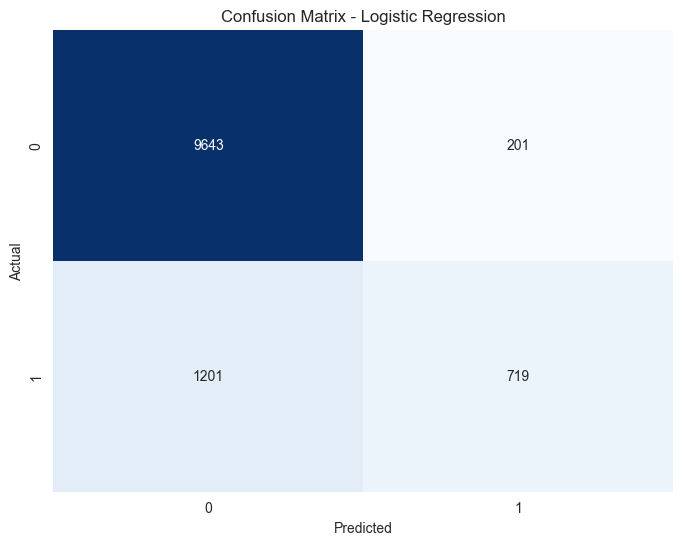


Confusion Matrix:
True Negatives:  9643
False Positives: 201
False Negatives: 1201
True Positives:  719


In [12]:
# Confusion Matrix
lr_cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'\nConfusion Matrix:')
print(f'True Negatives:  {lr_cm[0, 0]}')
print(f'False Positives: {lr_cm[0, 1]}')
print(f'False Negatives: {lr_cm[1, 0]}')
print(f'True Positives:  {lr_cm[1, 1]}')

## 5. Baseline Model 2: Decision Tree

Train a decision tree classifier as our second baseline model.

In [13]:
# Train Decision Tree
print('Training Decision Tree...')
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_model, y_train)
print('Training complete.')

Training Decision Tree...
Training complete.


In [14]:
# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Calculate evaluation metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

print('=' * 60)
print('DECISION TREE - EVALUATION METRICS')
print('=' * 60)
print(f'Accuracy:  {dt_accuracy:.4f}')
print(f'Precision: {dt_precision:.4f}')
print(f'Recall:    {dt_recall:.4f}')
print(f'F1 Score:  {dt_f1:.4f}')
print('=' * 60)

DECISION TREE - EVALUATION METRICS
Accuracy:  0.9449
Precision: 0.8980
Recall:    0.7474
F1 Score:  0.8158


In [15]:
# Print detailed classification report
print('\nDetailed Classification Report:')
print(classification_report(y_test, y_pred_dt))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      9844
           1       0.90      0.75      0.82      1920

    accuracy                           0.94     11764
   macro avg       0.93      0.87      0.89     11764
weighted avg       0.94      0.94      0.94     11764



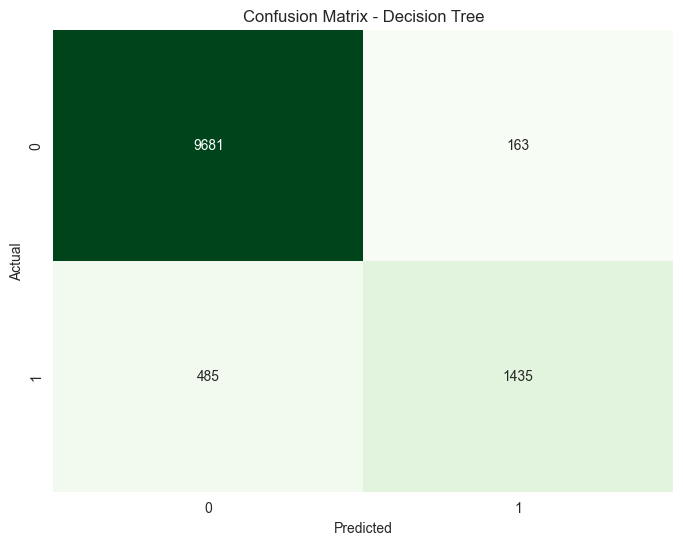


Confusion Matrix:
True Negatives:  9681
False Positives: 163
False Negatives: 485
True Positives:  1435


In [16]:
# Confusion Matrix
dt_cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'\nConfusion Matrix:')
print(f'True Negatives:  {dt_cm[0, 0]}')
print(f'False Positives: {dt_cm[0, 1]}')
print(f'False Negatives: {dt_cm[1, 0]}')
print(f'True Positives:  {dt_cm[1, 1]}')

## 6. Compare Baseline Models

Quick comparison of both baseline models.

In [17]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [lr_accuracy, dt_accuracy],
    'Precision': [lr_precision, dt_precision],
    'Recall': [lr_recall, dt_recall],
    'F1 Score': [lr_f1, dt_f1]
})

print('\n' + '=' * 80)
print('BASELINE MODELS COMPARISON')
print('=' * 80)
print(comparison.to_string(index=False))
print('=' * 80)


BASELINE MODELS COMPARISON
              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.880823   0.781522 0.374479  0.506338
      Decision Tree  0.944917   0.897997 0.747396  0.815804


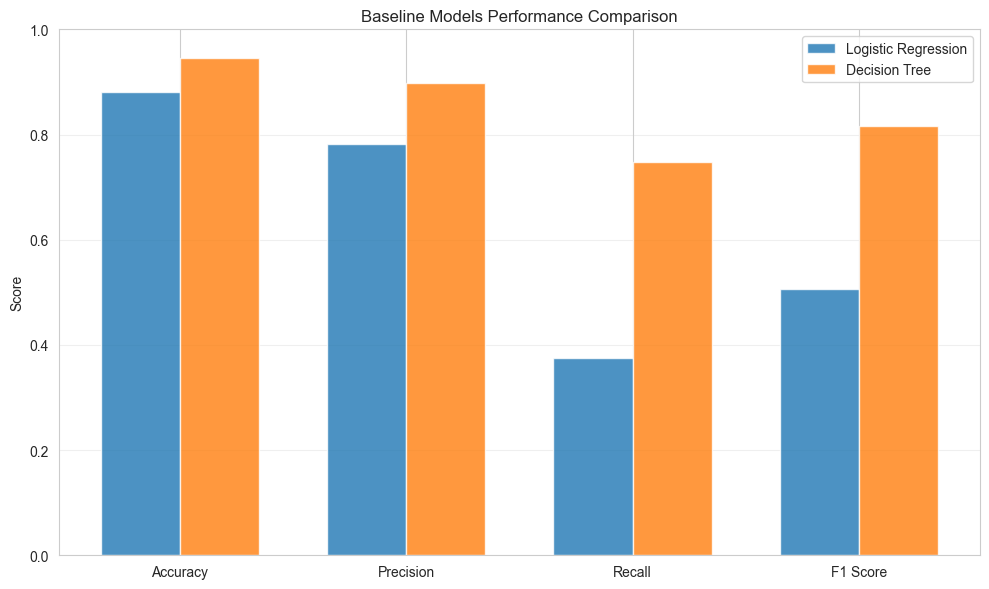

In [18]:
# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, [lr_accuracy, lr_precision, lr_recall, lr_f1], width, label='Logistic Regression', alpha=0.8)
ax.bar(x + width/2, [dt_accuracy, dt_precision, dt_recall, dt_f1], width, label='Decision Tree', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Baseline Models Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We have successfully built and evaluated two baseline models:

1. **Logistic Regression**: Simple linear model that provides a good starting point
2. **Decision Tree**: Non-linear model that can capture more complex patterns

**Key Observations:**
- These baseline models give us a performance benchmark to improve upon
- In AML detection, **recall** is often more important than precision (we want to catch as many fraudulent transactions as possible)
- The class imbalance may be affecting model performance

**Next Steps:**
- Handle class imbalance using techniques like class weighting or resampling
- Try more advanced models (Random Forest, XGBoost)
- Tune decision thresholds to optimize for recall